In [ ]:
import argparse
from parametricSN.models.models_factory import baseModelFactory
from models.model import SlotSAR
from models.model import Visual_Encoder
import slot_utils as utils
import torch
import argparse
import cv2
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings("ignore")


def MINMAX_Norm(img):
  img = (img-np.min(img))/(np.max(img)-np.min(img))
  return img

def tensor_to_array(tensor):
    return tensor.detach().cpu().numpy()

def show_tensor(tensor, title=None, cmap='gray'):
    array = tensor.detach().cpu().numpy()
    plt.imshow(array, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


class ImageTransform(): 
    def __init__(self):
        self.data_transform = transforms.Compose([
                transforms.ToTensor()])
        
    def __call__(self, img):
        return self.data_transform(img)

def get_args_jupyter():
    parser = argparse.ArgumentParser("SlotSAR")

    # === Data Related Parameters ===
    parser.add_argument('--resize_to',  nargs='+', type=int, default=[224, 224])

    # === ViT Related Parameters ===
    parser.add_argument('--encoder', type=str, default="saratrx-16", 
                        choices=["dinov2-vitb-14", "dino-vitb-16", "dino-vitb-8", "sup-vitb-16", "saratrx-16"])
    parser.add_argument('--token_num', type=int, default=196)
    parser.add_argument('--patch_size', type=int, default=16)

    # === Slot Attention Related Parameters ===
    parser.add_argument('--num_slots', type=int, default=2)
    parser.add_argument('--slot_att_iter', type=int, default=3)
    parser.add_argument('--slot_dim', type=int, default=256)
    parser.add_argument('--query_opt', action="store_true")
    parser.add_argument('--ISA', action="store_true")

    # === Training Related Parameters ===    
    parser.add_argument('--learning_rate', type=float, default=7e-4)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--num_epochs', type=int, default=100)

    # === Misc ===
    parser.add_argument('--use_checkpoint', action="store_true")
    parser.add_argument('--checkpoint_path', type=str, default=None)
    parser.add_argument('--validation_epoch', type=int, default=10)

    parser.add_argument('--model_save_path', type=str, default="saved_models_finetune/")
    
    parser.add_argument('--height', type=int, default=128)
    parser.add_argument('--width', type=int, default=128)
    parser.add_argument('--J', type=int, default=2)
    parser.add_argument('--second_order', type=bool, default=True)
    parser.add_argument('--initialization', type=str, default='Tight-Frame')
    parser.add_argument('--seed', type=int, default=17)
    parser.add_argument('--learnable', type=bool, default=True)
    parser.add_argument('--lr_orientation', type=float, default=0.1)
    parser.add_argument('--lr_scattering', type=float, default=0.1)
    parser.add_argument('--filter_video', type=bool, default=False)
    parser.add_argument('--parameterization', type=str, default='canonical')
    
    args = parser.parse_args(args=[])
    return args


In [2]:
args = get_args_jupyter()
utils.init_distributed_mode(args)
utils.fix_random_seeds(args.seed)

random.seed(42)
torch.manual_seed(42)
generator = torch.Generator()
generator.manual_seed(42)

Will run the code on one GPU.
| distributed init (rank 0): env://


In [3]:
vis_encoder = Visual_Encoder(args).cuda()
sc_encoder = baseModelFactory(
        architecture='scattering',
        J=args.J,
        N=args.height,
        M=args.width,
        second_order=args.second_order,
        initialization=args.initialization,
        seed=args.seed,
        learnable=args.learnable,
        lr_orientation=args.lr_orientation,
        lr_scattering=args.lr_scattering,
        filter_video=args.filter_video,
        parameterization=args.parameterization
    ).cuda()
slotsar_model = SlotSAR(args).cuda()


In [4]:
checkpoint = torch.load("weights/weight_SOC40.pt")
slotsar_model.load_state_dict(checkpoint['slotsar'])
sc_encoder.load_state_dict(checkpoint['sc_encoder'])

vis_encoder.eval()
sc_encoder.eval()
slotsar_model.eval()

SlotSAR(
  (mlsa): MLSA(
    (Q): Linear(in_features=256, out_features=256, bias=False)
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (update_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (gru): GRUCell(256, 256)
    (mlp): MLP(
      (layer1): Linear(in_features=256, out_features=1024, bias=True)
      (layer2): Linear(in_features=1024, out_features=256, bias=True)
      (activation): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (K_dino): Sequential(
      (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
    )
    (K_wsn): Sequential(
      (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
    )
    (V_dino): Sequential(
      (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (1): Lin

In [ ]:

import os
import glob

tif_paths = sorted(glob.glob("example_img/SOC_40classes/**/*.tif", recursive=True))
print(tif_paths)

['example_img/SOC_40classes/Great_Wall_Voleex_C50/KU_HH_15_150_331253.tif', 'example_img/SOC_40classes/Great_Wall_Voleex_C50/KU_HH_15_210_66813.tif', 'example_img/SOC_40classes/Great_Wall_Voleex_C50/KU_HH_15_30_269258.tif']


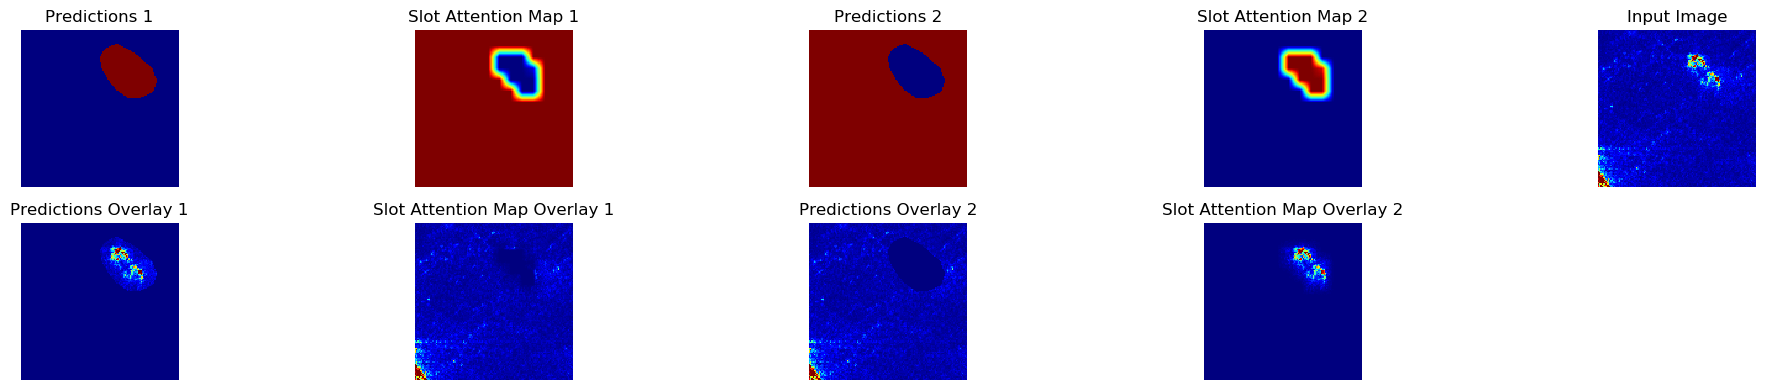

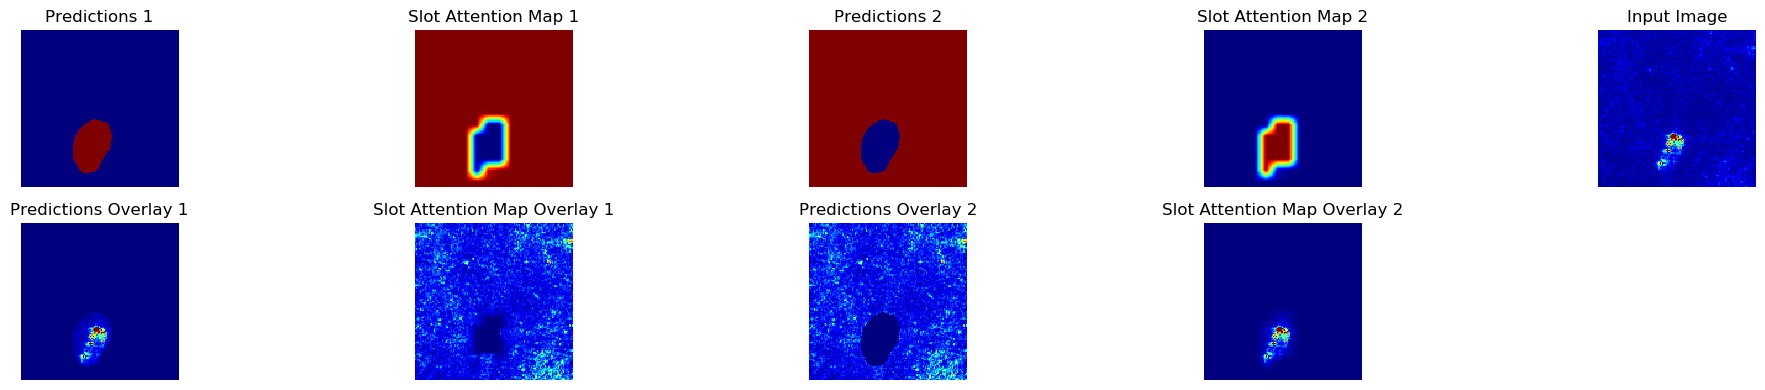

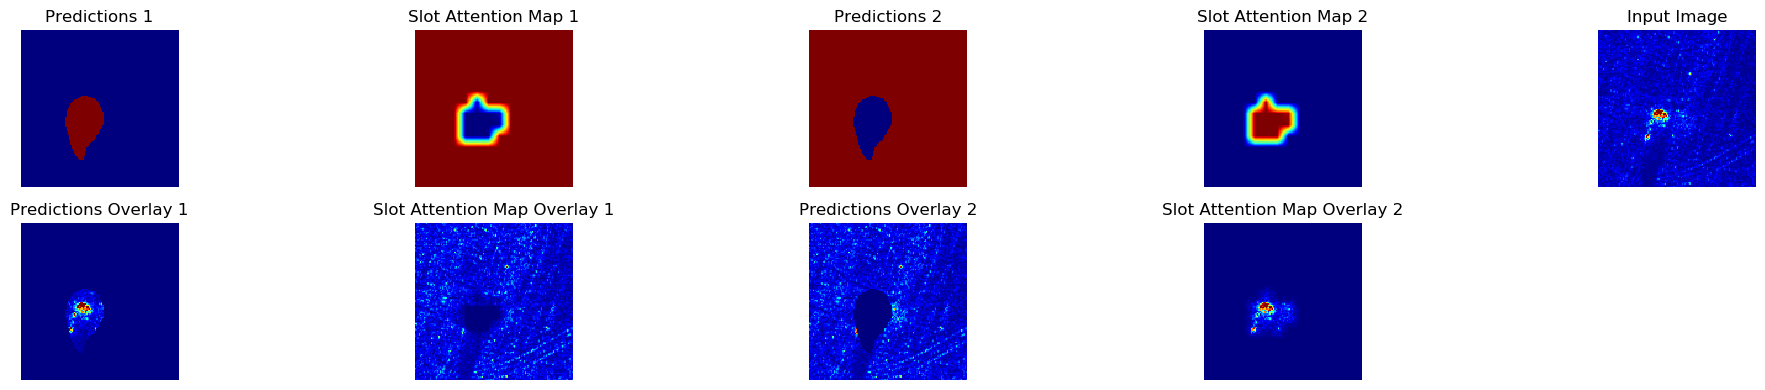

In [ ]:
img_transform=ImageTransform()

for path in tif_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.abs(img)   
    img_raw = MINMAX_Norm(img) # for WSN
    H_t, W_t = [224, 224]
    img_vis = cv2.resize(img_raw, (H_t, W_t))
    img_vis = np.stack([img_vis] * 3, axis=-1) # for SARATRX

    img_vis_transformed = img_transform(img_vis).float()
    img_vis_transformed = img_vis_transformed.unsqueeze(0).cuda()
    img_transformed = img_transform(img_raw).float()
    img_transformed = img_transformed.unsqueeze(0).cuda()
    
    features_vis = vis_encoder(img_vis_transformed)
    features_sc = sc_encoder(img_transformed)
    features_sc = features_sc.sum(dim=1, keepdim=True)
    features_sc = F.interpolate(features_sc, size=(14, 14), mode='bilinear', align_corners=False)

    _, _, masks, attns, _, _ = slotsar_model(features_vis, features_sc)
    
    masks1 = masks.view(-1, 2, 14, 14)
    attns1 = attns.view(-1, 2, 14, 14)

    predictions = F.interpolate(masks1, size=(128, 128), mode="bilinear")
    predictions = torch.argmax(predictions, dim=1)
    resized_img = F.interpolate(img_transformed[0,0:1,:,:].unsqueeze(0), size=(128,128), mode='bilinear').squeeze()

    slotmap1 = attns1[0, 0, :, :].unsqueeze(0).unsqueeze(0)
    slotmap1 = (slotmap1 - slotmap1.min()) / (slotmap1.max() - slotmap1.min())
    slotmap1 = F.interpolate(slotmap1, size=(128,128), mode='bilinear').squeeze()

    slotmap2 = attns1[0, 1, :, :].unsqueeze(0).unsqueeze(0)
    slotmap2 = (slotmap2 - slotmap2.min()) / (slotmap2.max() - slotmap2.min())
    slotmap2 = F.interpolate(slotmap2, size=(128,128), mode='bilinear').squeeze()
    
    reverse_predictions = 1-predictions[0, :, :].squeeze(0)

    images = [
        tensor_to_array(predictions[0, :, :].squeeze(0)),
        tensor_to_array(slotmap1),
        tensor_to_array(reverse_predictions),
        tensor_to_array(slotmap2),
        tensor_to_array(resized_img),
        tensor_to_array(resized_img * predictions[0, :, :].squeeze(0)),
        tensor_to_array(resized_img * slotmap1),
        tensor_to_array(resized_img * reverse_predictions),
        tensor_to_array(resized_img * slotmap2)
    ]

    titles = [
        "Predictions 1",
        "Slot Attention Map 1",
        "Predictions 2",
        "Slot Attention Map 2",
        "Input Image",
        "Predictions Overlay 1",
        "Slot Attention Map Overlay 1",
        "Predictions Overlay 2",
        "Slot Attention Map Overlay 2"
    ]
    plt.figure(figsize=(20, 4))
    for i in range(9):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='jet')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()